<a href="https://colab.research.google.com/github/zergswim/GAN/blob/main/Chapter_7_SGAN(edited_view_sample).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7장: SGAN

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/gans-in-action/blob/master/chapter-7/Chapter_7_SGAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import backend as K

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                                     Dropout, Flatten, Input, Lambda, Reshape)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

## 데이터셋

In [2]:
class Dataset:
    def __init__(self, num_labeled):

        # 훈련에 사용할 레이블된 샘플 개수
        self.num_labeled = num_labeled

        # MNIST 데이터셋 적재
        (self.x_train, self.y_train), (self.x_test,
                                       self.y_test) = mnist.load_data()

        def preprocess_imgs(x):
            # [0, 255] 사이 흑백 픽셀 값을 [–1, 1] 사이로 변환
            x = (x.astype(np.float32) - 127.5) / 127.5
            # 너비 × 높이 × 채널로 이미지 차원을 확장
            x = np.expand_dims(x, axis=3)
            return x

        def preprocess_labels(y):
            return y.reshape(-1, 1)

        # 훈련 데이터
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)

        # 테스트 데이터
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)

    def batch_labeled(self, batch_size):
        # 레이블된 이미지와 레이블의 랜덤 배치 만들기
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        # 레이블이 없는 이미지의 랜덤 배치 만들기
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0],
                                batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test

In [3]:
num_labeled = 100
dataset = Dataset(num_labeled)

# SGAN

In [4]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)
z_dim = 100
num_classes = 10

## 생성자

In [5]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))
    return model

## 판별자

In [6]:
def build_discriminator_net(img_shape):
    model = Sequential()
    model.add( Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add( Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add( Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    model.add(Flatten())
    # model.add(Dense(num_classes))
    return model

In [7]:
def build_discriminator_supervised(discriminator_net):
    model = Sequential()
    model.add(discriminator_net)
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [8]:
def build_discriminator_unsupervised(discriminator_net):
    model = Sequential()
    model.add(discriminator_net)

    # model.add(Dense(1, activation='sigmoid'))

    model.add(Dense(num_classes))

    def predict(x):
        # 진짜 클래스에 대한 확률 분포를 진짜 대 가짜의 이진 확률로 변환합니다.
        prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 앞서 정의한 진짜 대 가짜 확률을 출력하는 뉴런
    model.add(Lambda(predict))

    return model

## 모델 구성

In [9]:
# def build_gan(generator, discriminator):

#     model = Sequential()

#     # 생성자와 판별자 모델을 연결하기
#     model.add(generator)
#     model.add(discriminator)

#     return model

### 판별자

In [10]:
discriminator_net = build_discriminator_net(img_shape)
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=0.0003))

discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy', optimizer=Adam())

discriminator_supervised.summary()
discriminator_unsupervised.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2048)              92672     
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 113,162
Trainable params: 113,162
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2048)              92672     
                                                                 
 dense_1 (Dense)          

### 생성자

In [11]:
# 생성자를 만듭니다.
import tensorflow as tf
generator = build_generator(z_dim)
optimizer_g = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean()

@tf.function
def train_step(z, real):
    with tf.GradientTape() as tape:
        gen_imgs = generator(z)
        pred = discriminator_unsupervised(gen_imgs) # or discriminator_supervised?
        loss = tf.keras.losses.binary_crossentropy(real, pred) #? real or fake?

    gradients = tape.gradient(loss, generator.trainable_variables)
    optimizer_g.apply_gradients(zip(gradients, generator.trainable_variables))

    train_loss(loss)
    g_loss = train_loss.result()
    
    return gen_imgs, g_loss

# generator = build_generator(z_dim)

# # 생성자 훈련을 위해 판별자의 모델 파라미터를 동결합니다.
# discriminator_unsupervised.trainable = False

# # 생성자를 훈련하기 위해 고정된 판별자로 GAN 모델을 만들고 컴파일합니다.
# # 노트: 비지도 학습용 판별자를 사용하세요.
# gan = build_gan(generator, discriminator_unsupervised)
# gan.compile(loss='binary_crossentropy', optimizer=Adam())

## 훈련

In [12]:
supervised_losses = []
unsupervised_losses = []
gen_losses = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        imgs, labels = dataset.batch_labeled(batch_size)

        labels = to_categorical(labels, num_classes=num_classes)
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)

        z = np.random.normal(0, 1, (batch_size, z_dim))
        # gen_imgs = generator.predict(z)
        gen_imgs, g_loss = train_step(z, real)

        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)

        d_loss_real = discriminator_unsupervised.train_on_batch(imgs_unlabeled, real)
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)

        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  생성자 훈련
        # ---------------------

        # 가짜 이미지의 배치를 생성합니다.
        # z = np.random.normal(0, 1, (batch_size, z_dim))
        # gen_imgs = generator.predict(z)

        # 생성자를 훈련합니다.
        # g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))

        if (iteration + 1) % sample_interval == 0:

            # 훈련이 끝난 후 그래프를 그리기 위해 판별자의 지도 학습 분류 손실을 기록합니다.
            supervised_losses.append(d_loss_supervised)
            unsupervised_losses.append(d_loss_unsupervised)
            gen_losses.append(g_loss)
            iteration_checkpoints.append(iteration + 1)

            # 훈련 과정을 출력합니다.
            print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy,
                   d_loss_unsupervised, g_loss))
            # print(
            #     "%d [D loss supervised: %.4f, acc.: %.2f%%] [G loss: %f]"
            #     % (iteration + 1, d_loss_supervised, 100 * accuracy, g_loss))
            sample_images(generator)
            
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
 

## 모델 훈련과 출력 조사

800 [D loss supervised: 0.0337, acc.: 100.00%] [D loss unsupervised: 0.0085] [G loss: 3.804258]


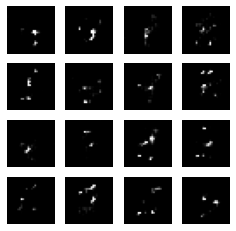

1600 [D loss supervised: 0.0025, acc.: 100.00%] [D loss unsupervised: 0.5846] [G loss: 2.898906]


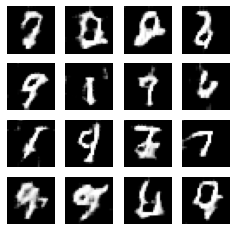

2400 [D loss supervised: 0.0057, acc.: 100.00%] [D loss unsupervised: 0.6372] [G loss: 2.388779]


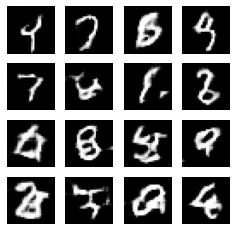

3200 [D loss supervised: 0.0045, acc.: 100.00%] [D loss unsupervised: 0.3770] [G loss: 2.106839]


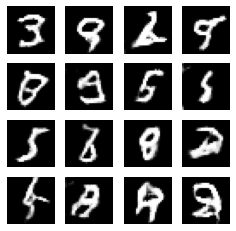

4000 [D loss supervised: 0.0015, acc.: 100.00%] [D loss unsupervised: 0.6370] [G loss: 1.927865]


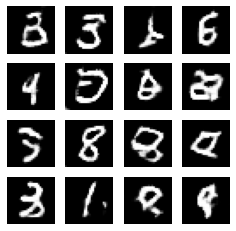

4800 [D loss supervised: 0.0123, acc.: 100.00%] [D loss unsupervised: 0.6207] [G loss: 1.792009]


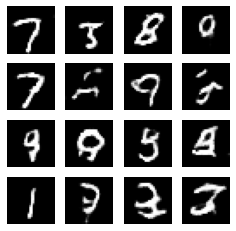

5600 [D loss supervised: 0.0031, acc.: 100.00%] [D loss unsupervised: 0.4731] [G loss: 1.694076]


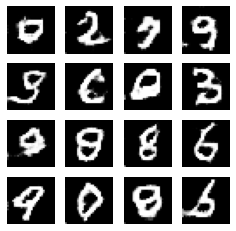

6400 [D loss supervised: 0.0071, acc.: 100.00%] [D loss unsupervised: 0.4462] [G loss: 1.633092]


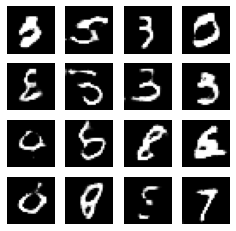

7200 [D loss supervised: 0.0007, acc.: 100.00%] [D loss unsupervised: 0.6145] [G loss: 1.593175]


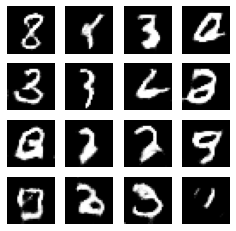

8000 [D loss supervised: 0.0006, acc.: 100.00%] [D loss unsupervised: 0.4422] [G loss: 1.584937]


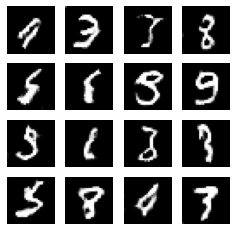

In [13]:
iterations = 8000
batch_size = 32
sample_interval = 800

train(iterations, batch_size, sample_interval)

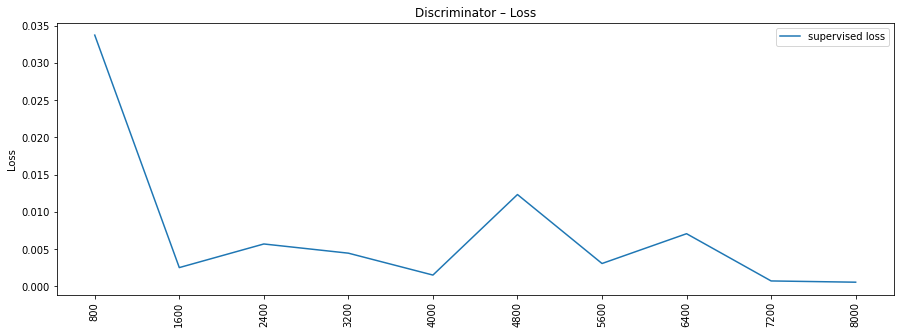

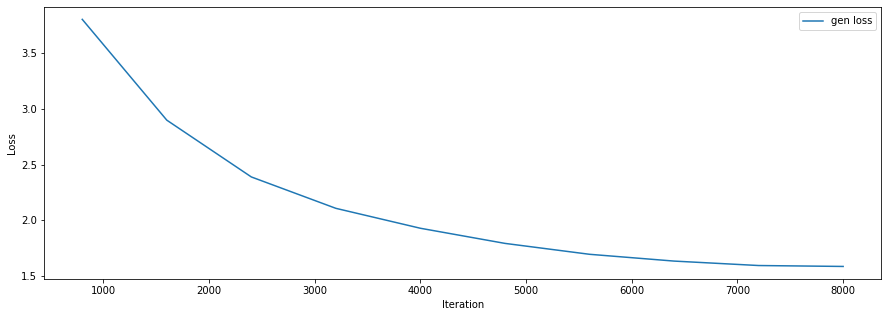

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, np.array(supervised_losses), label="supervised loss")
# plt.plot(iteration_checkpoints, np.array(unsupervised_losses), label="unsupervised loss")
plt.xticks(iteration_checkpoints, rotation=90)
plt.title("Discriminator – Loss")
# plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, np.array(gen_losses), label="gen loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()


## SGAN 분류기 – 훈련 세트와 테스트 세트 정확도

In [15]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

_, accuracy = discriminator_supervised.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 15ms/step - loss: 5.4663e-05 - accuracy: 1.0000
Training Accuracy: 100.00%


In [16]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 3ms/step - loss: 0.9304 - accuracy: 0.7989
Test Accuracy: 79.89%


# 완전히 지도 학습으로 훈련된 분류기

In [17]:
# SGAN 판별자와 같은 네트워크 구조를 가진 지도 학습 분류기
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

In [18]:
imgs, labels = dataset.training_set()

# 레이블을 원-핫 인코딩합니다.
labels = to_categorical(labels, num_classes=num_classes)

training = mnist_classifier.fit(x=imgs, y=labels, batch_size=32, epochs=30, verbose=1)
losses = training.history['loss']
accuracies = training.history['accuracy']

Epoch 1/30
4/4 [==============================] - 0s 24ms/step - loss: 2.3124 - accuracy: 0.0900
Epoch 2/30
4/4 [==============================] - 0s 5ms/step - loss: 2.2067 - accuracy: 0.3000
Epoch 3/30
4/4 [==============================] - 0s 5ms/step - loss: 2.1246 - accuracy: 0.4200
Epoch 4/30
4/4 [==============================] - 0s 6ms/step - loss: 2.0289 - accuracy: 0.4700
Epoch 5/30
4/4 [==============================] - 0s 5ms/step - loss: 1.8720 - accuracy: 0.5000
Epoch 6/30
4/4 [==============================] - 0s 5ms/step - loss: 1.6687 - accuracy: 0.5400
Epoch 7/30
4/4 [==============================] - 0s 5ms/step - loss: 1.3954 - accuracy: 0.5900
Epoch 8/30
4/4 [==============================] - 0s 5ms/step - loss: 1.1827 - accuracy: 0.7300
Epoch 9/30
4/4 [==============================] - 0s 5ms/step - loss: 0.9227 - accuracy: 0.7800
Epoch 10/30
4/4 [==============================] - 0s 5ms/step - loss: 0.7568 - accuracy: 0.7900
Epoch 11/30
4/4 [=====================

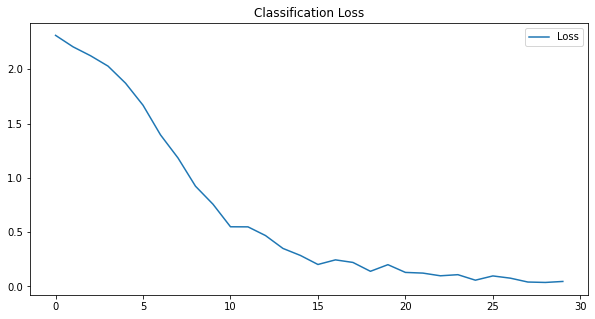

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()
plt.show()

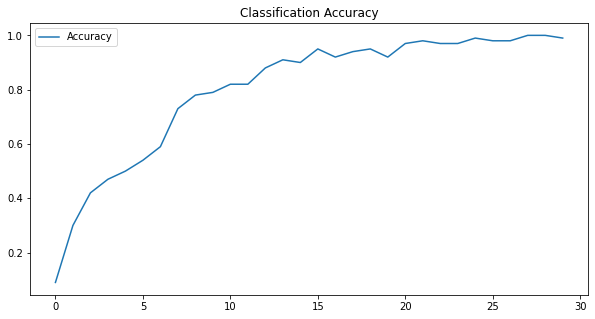

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy")
plt.legend()
plt.show()

In [21]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# 훈련 세트에 대한 분류 정확도를 계산합니다.
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 4ms/step - loss: 0.0116 - accuracy: 1.0000
Training Accuracy: 100.00%


In [22]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# 테스트 세트에 대한 분류 정확도를 계산합니다.
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 3ms/step - loss: 1.1973 - accuracy: 0.7048
Test Accuracy: 70.48%
